In [1]:
import os
import sys

import ccxt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from defillama2 import DefiLlama
from sklearn import linear_model

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()))))

from src.analysis_logic import AnalysisLogic, FitMethods
import src.helpers as helpers

sns.set_theme()
sns.set_style("dark")

In [2]:
save_folderpath = os.path.join("..", "images", "8_BitcoinVolatilityAndCorrelation")

Data source: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

# Get historical data

In [3]:
filepath = os.path.join("..", "data", "bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df = pd.read_csv(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


## Convert timestamps to datatime objects and set as index

In [4]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit='s')
df = df.set_index("Timestamp", drop=True)
df = df[df.index > pd.to_datetime('2012-01-01')]

## Check for null values

<AxesSubplot: ylabel='Timestamp'>

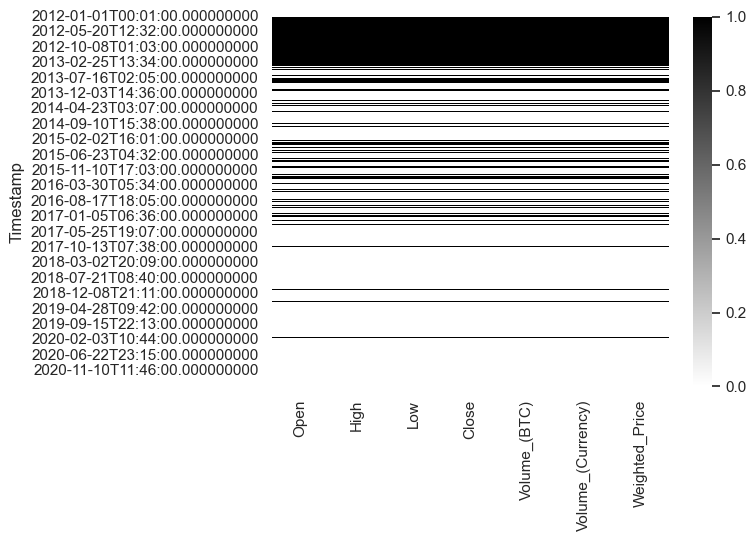

In [5]:
sns.heatmap(df.isnull(), cmap="binary", vmin=0, vmax=1)

## Drop null values

In [6]:
df = df.dropna().reset_index().set_index("Timestamp", drop=True)

<AxesSubplot: ylabel='Timestamp'>

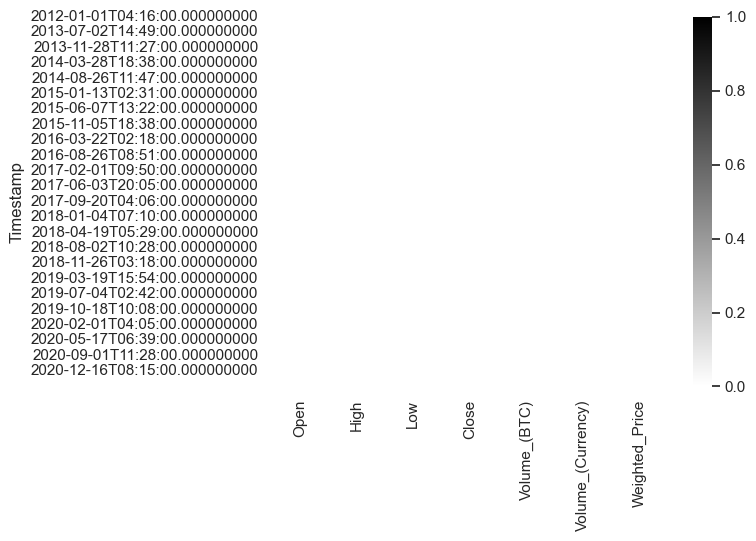

In [7]:
# Double check to see if any null values remain
sns.heatmap(df.isnull(), cmap="binary", vmin=0, vmax=1)

## Check for outliers

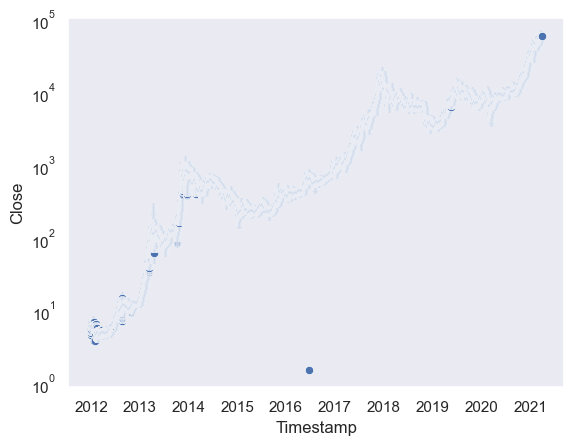

In [8]:
ax = sns.scatterplot(x=df.index, y="Close", data=df)
ax.set_yscale("log")

## Resample data
Since we don't really need minute data for our analysis, we can just resample and see if it disappears

In [9]:
# month start frequency
df = df.resample("MS").apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
})

No more outliers in monthly data

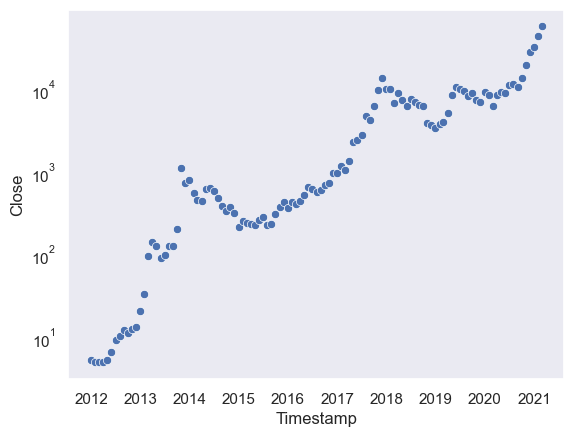

In [10]:
ax = sns.scatterplot(x=df.index, y="Close", data=df)
ax.set_yscale("log")

In [11]:
df.tail()

,Open,High,Low,Close
Timestamp,,,,
2020-11-01,13799.44,19864.15,13220.00,19700.19
2020-12-01,19703.53,29300.00,17569.58,28992.79
2021-01-01,28999.63,42000.00,27734.00,33141.38
2021-02-01,33110.32,58354.14,32333.01,45240.96
2021-03-01,45261.56,61781.83,45020.25,58778.18


However, the data is not the most recent, only until Mar 2021. Lets get the latest data

# Get latest data and concatenate

In [12]:
binance = ccxt.binance()
data = binance.fetch_ohlcv(
    'BTC/USDT', '1M', since=int((df.index[-1] + pd.Timedelta(days=31)).timestamp() * 1000))

df2 = pd.DataFrame(
    data, columns=["Timestamp", "Open", "High", "Low", "Close", "Volume"])

df2["Timestamp"] = pd.to_datetime(df2["Timestamp"], unit='ms')
df2 = df2.set_index("Timestamp", drop=True)
df2 = df2.drop(["Volume"], axis=1)

In [13]:
df = pd.concat([df, df2])

# Plot

Text(0.5, 0, 'Time')

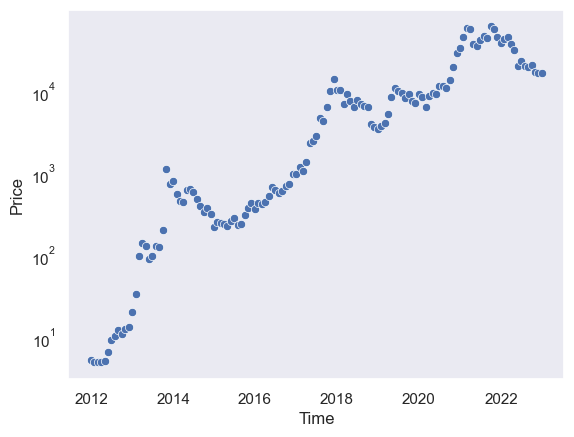

In [14]:
ax = sns.scatterplot(x=df.index, y="Close", data=df)
ax.set_yscale("log")

ax.set_ylabel("Price")
ax.set_xlabel("Time")

## Monthly returns

Text(0.5, 0, 'Time')

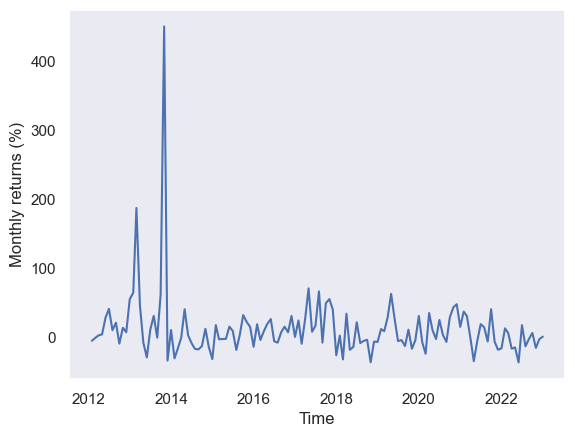

In [15]:
ax = sns.lineplot(x=df.index, y=df["Close"].pct_change() * 100)

ax.set_ylabel("Monthly returns (%)")
ax.set_xlabel("Time")

# Calculate volatility

In [16]:
months_in_window = 3
df = helpers.calculate_annualized_volatility(df, window=months_in_window, num_windows_in_year=12)

$$  $$

## Fit with linear regression model from 2018 onwards

Convert datetime index to number of months from starting date, x data needs to be reshaped for sklearn fitting

In [17]:
linear_start_index = 85
x = df.index[linear_start_index:].factorize()[0].reshape(-1, 1)
y = df["real_volatility_close"].values[linear_start_index:]

regr = linear_model.LinearRegression()
regr.fit(x, y)

print(df.index[linear_start_index])

2019-02-01 00:00:00


In [18]:
analysis = AnalysisLogic()
fit_x, fit_y, result = analysis.perform_fit(
    x=df.index[months_in_window:].factorize()[0],
    y=df["real_volatility_close"].values[months_in_window:],
    fit_function=FitMethods.sineexponentialdecay
)

x_extra = np.arange(0, len(df.index))

<AxesSubplot: title={'center': '(((Model(amplitude_function) * Model(bare_sine_function)) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))'}, ylabel='residuals'>

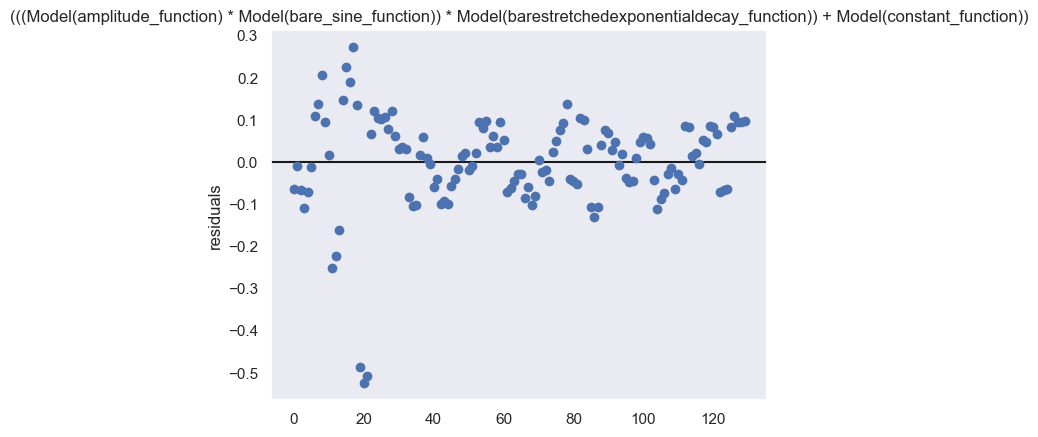

In [19]:
result.plot_residuals()

In [20]:
result

In [21]:
dxy = yf.download("DX=F", interval="1mo", start=df.index[0])

[*********************100%***********************]  1 of 1 completed


In [22]:
google = yf.download("GOOG", interval="1mo", start=df.index[0])

[*********************100%***********************]  1 of 1 completed


In [23]:
dxy = helpers.calculate_annualized_volatility(dxy, window=months_in_window, num_windows_in_year=12)

In [24]:
google = helpers.calculate_annualized_volatility(google, window=months_in_window, num_windows_in_year=12)

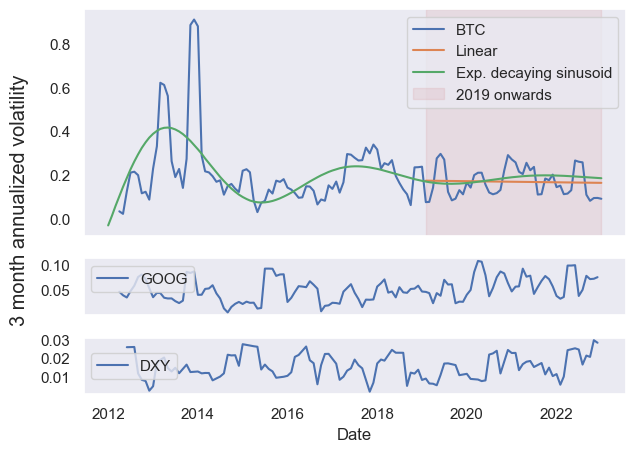

In [25]:
fig, (ax, ax1, ax2) = plt.subplots(nrows=3, figsize=(7, 5), sharex=True, sharey=False,
                                   gridspec_kw={"height_ratios": [4, 1, 1]})

# BTC
sns.lineplot(x=df.index, y="real_volatility_close", data=df, ax=ax, label="BTC")
sns.lineplot(x=df.index[linear_start_index:], y=regr.predict(x), ax=ax, linestyle="-", label="Linear")
sns.lineplot(x=df.index, y=result.eval(x=x_extra), ax=ax, linestyle="-", label="Exp. decaying sinusoid")

ax.set_ylabel("")

ax.axvspan(df.index[linear_start_index], df.index[-1], alpha=0.1, color="C3",
           label=f"{df.index[linear_start_index].strftime('%Y')} onwards")
ax.legend()

# GOOGLE
sns.lineplot(x=google.index, y="real_volatility_close", data=google, ax=ax1, label="GOOG")
ax1.set_ylabel("")
ax1.set_xlabel("")

# DXY
sns.lineplot(x=dxy.index, y="real_volatility_close", data=dxy, ax=ax2, label="DXY")
ax2.set_ylabel("")
ax2.legend()

fig.supylabel("3 month annualized volatility")

fig.savefig(os.path.join(save_folderpath, "btc_volatility_comparison.jpg"), dpi=300, bbox_inches="tight")

# Correlation with the stock market and CPI

In [26]:
nasdaq = yf.download("^IXIC", interval="1mo", start=df.index[0])
nasdaq.info()

spy = yf.download("SPY", interval="1mo", start=df.index[0])
spy.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2012-01-01 to 2022-12-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       132 non-null    float64
 1   High       132 non-null    float64
 2   Low        132 non-null    float64
 3   Close      132 non-null    float64
 4   Adj Close  132 non-null    float64
 5   Volume     132 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 7.2 KB
[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2012-01-01 to 2022-12-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       132 non-null    float64
 1   High       132 non-null    float64
 2   Low        132 non-null    float64
 3   Close      132 non-null    float64
 4   A

In [27]:
filepath = os.path.join("..", "data", "FEDFUNDS.csv")
fedfunds = pd.read_csv(filepath)
fedfunds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      131 non-null    object 
 1   FEDFUNDS  131 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


In [28]:
fedfunds["DATE"] = pd.to_datetime(fedfunds["DATE"])
fedfunds = fedfunds.set_index("DATE", drop=True)

In [29]:
filepath = os.path.join("..", "data", "CORESTICKM159SFRBATL.csv")
cpi = pd.read_csv(filepath)
cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATE                  131 non-null    object 
 1   CORESTICKM159SFRBATL  131 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


In [30]:
cpi["DATE"] = pd.to_datetime(cpi["DATE"])
cpi = cpi.set_index("DATE", drop=True)

Reset indexes to the smallest common timestamps (in this case FRED data)

In [31]:
idx = df.index.intersection(cpi.index)

df = df.loc[idx]
nasdaq = nasdaq.loc[idx]
spy = nasdaq.loc[idx]

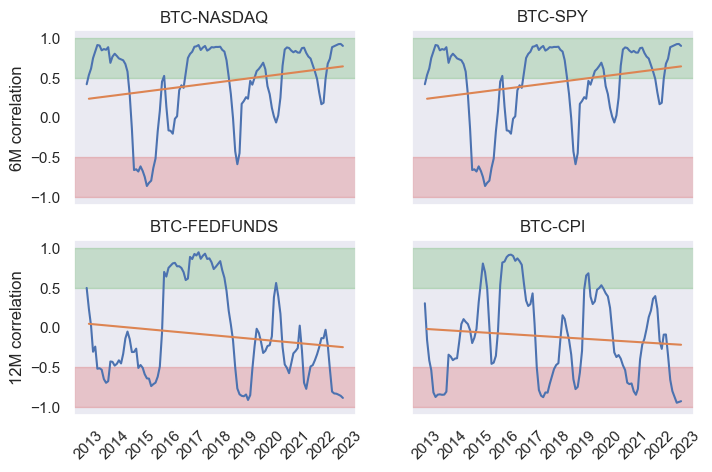

In [32]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex="col", sharey="row", figsize=(8, 5))

rolling_window = 12

# BTC-NASDAQ
btc_nasdaq_correlation = df["Close"].rolling(rolling_window).corr(nasdaq["Close"])
regr = linear_model.LinearRegression()
X = df.index[rolling_window:].factorize()[0].reshape(-1, 1)
regr.fit(X=X, y=btc_nasdaq_correlation.values[rolling_window:])

ax1.plot(df.index, btc_nasdaq_correlation)
ax1.plot(df.index[rolling_window:], regr.predict(X), linestyle="-")
ax1.set_title(f"BTC-NASDAQ")

ax1.axhspan(ymin=0.5, ymax=1, alpha=0.2, color="tab:green")
ax1.axhspan(ymin=-0.5, ymax=-1, alpha=0.2, color="tab:red")

ax1.set_ylabel("6M correlation")

# BTC-SPY
btc_spy_correlation = df["Close"].rolling(rolling_window).corr(spy["Close"])
regr = linear_model.LinearRegression()
X = df.index[rolling_window:].factorize()[0].reshape(-1, 1)
regr.fit(X=X, y=btc_spy_correlation.values[rolling_window:])

ax2.plot(df.index, btc_spy_correlation)
ax2.plot(df.index[rolling_window:], regr.predict(X), linestyle="-")
ax2.set_title(f"BTC-SPY")

ax2.axhspan(ymin=0.5, ymax=1, alpha=0.2, color="tab:green")
ax2.axhspan(ymin=-0.5, ymax=-1, alpha=0.2, color="tab:red")

rolling_window = 12

# BTC-FEDFUNDS
btc_fedfunds_correlation = df["Close"].rolling(rolling_window).corr(fedfunds["FEDFUNDS"])

regr = linear_model.LinearRegression()
X = df.index[rolling_window:].factorize()[0].reshape(-1, 1)
regr.fit(X=X, y=btc_fedfunds_correlation.values[rolling_window:])

ax3.plot(df.index, btc_fedfunds_correlation)
ax3.plot(df.index[rolling_window:], regr.predict(X), linestyle="-")
ax3.set_title(f"BTC-FEDFUNDS")

ax3.axhspan(ymin=0.5, ymax=1, alpha=0.2, color="tab:green")
ax3.axhspan(ymin=-0.5, ymax=-1, alpha=0.2, color="tab:red")

ax3.set_ylabel("12M correlation")

# BTC-CPI
btc_cpi_correlation = df["Close"].rolling(rolling_window).corr(cpi["CORESTICKM159SFRBATL"])

regr = linear_model.LinearRegression()
X = df.index[rolling_window:].factorize()[0].reshape(-1, 1)
regr.fit(X=X, y=btc_cpi_correlation.values[rolling_window:])

ax4.plot(df.index, btc_cpi_correlation)
ax4.plot(df.index[rolling_window:], regr.predict(X), linestyle="-")
ax4.set_title(f"BTC-CPI")

ax4.axhspan(ymin=0.5, ymax=1, alpha=0.2, color="tab:green")
ax4.axhspan(ymin=-0.5, ymax=-1, alpha=0.2, color="tab:red")
ax3.tick_params(axis='x', labelrotation=45)
ax4.tick_params(axis='x', labelrotation=45)

fig.savefig(os.path.join(save_folderpath, "btc_correlations.jpg"), dpi=300, bbox_inches="tight")

# Correlation with currency indexes

Need to resample BTC to extract a correlation

In [33]:
btc_q = df.resample("Q").apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
})

In [34]:
dxy = yf.download("DX=F", interval="1mo", start=df.index[0])

[*********************100%***********************]  1 of 1 completed


In [35]:
dxy = dxy.resample("Q").apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
})

In [36]:
len(btc_q), len(dxy)

(44, 44)

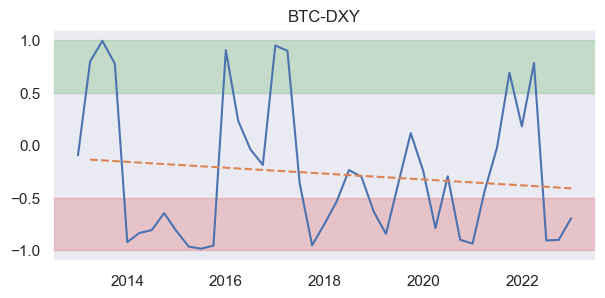

In [37]:
fig, (ax1) = plt.subplots(ncols=1, sharex="col", sharey="row", figsize=(7, 3))

rolling_window = 4

# BTC-NASDAQ
btc_dxy_correlation = btc_q["Close"].rolling(rolling_window).corr(dxy["Close"])
regr = linear_model.LinearRegression()
X = btc_q.index[rolling_window:].factorize()[0].reshape(-1, 1)
regr.fit(X=X, y=btc_dxy_correlation.values[rolling_window:])

ax1.plot(btc_q.index, btc_dxy_correlation)
ax1.plot(btc_q.index[rolling_window:], regr.predict(X), linestyle="--")
ax1.set_title(f"BTC-DXY")

ax1.axhspan(ymin=0.5, ymax=1, alpha=0.2, color="tab:green")
ax1.axhspan(ymin=-0.5, ymax=-1, alpha=0.2, color="tab:red")

In [38]:
filepath = os.path.join("..", "data", "FEDFUNDS.csv")
fedfunds = pd.read_csv(filepath)
fedfunds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      131 non-null    object 
 1   FEDFUNDS  131 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


In [39]:
fedfunds["DATE"] = pd.to_datetime(fedfunds["DATE"])
fedfunds = fedfunds.set_index("DATE", drop=True)

In [40]:
len(fedfunds), len(df)

(131, 131)

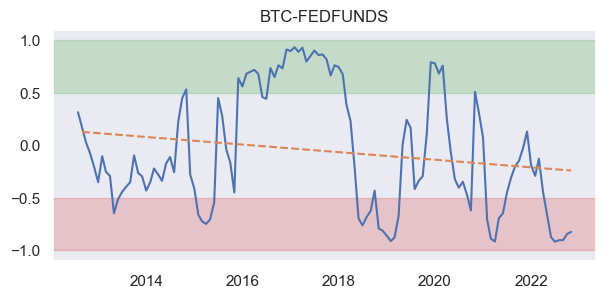

In [41]:
fig, (ax1) = plt.subplots(ncols=1, sharex="col", sharey="row", figsize=(7, 3))

rolling_window = 8

# BTC-NASDAQ
btc_fedfunds_correlation = df["Close"].rolling(rolling_window).corr(fedfunds["FEDFUNDS"])
regr = linear_model.LinearRegression()
X = df.index[rolling_window:].factorize()[0].reshape(-1, 1)
regr.fit(X=X, y=btc_fedfunds_correlation.values[rolling_window:])

ax1.plot(df.index, btc_fedfunds_correlation)
ax1.plot(df.index[rolling_window:], regr.predict(X), linestyle="--")
ax1.set_title(f"BTC-FEDFUNDS")

ax1.axhspan(ymin=0.5, ymax=1, alpha=0.2, color="tab:green")
ax1.axhspan(ymin=-0.5, ymax=-1, alpha=0.2, color="tab:red")

Just to make sure everything is working as expected, we can look at DXY and the FEDFUNDS

In [42]:
fedfunds_q = fedfunds.resample("Q").apply({
    'FEDFUNDS': 'last'
})

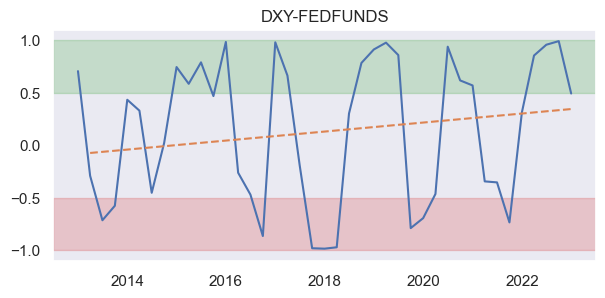

In [43]:
fig, (ax1) = plt.subplots(ncols=1, sharex="col", sharey="row", figsize=(7, 3))

rolling_window = 4

# BTC-NASDAQ
dxy_fedfunds_correlation = dxy["Close"].rolling(rolling_window).corr(fedfunds_q["FEDFUNDS"])
regr = linear_model.LinearRegression()
X = dxy.index[rolling_window:].factorize()[0].reshape(-1, 1)
regr.fit(X=X, y=dxy_fedfunds_correlation.values[rolling_window:])

ax1.plot(dxy.index, dxy_fedfunds_correlation)
ax1.plot(dxy.index[rolling_window:], regr.predict(X), linestyle="--")
ax1.set_title(f"DXY-FEDFUNDS")

ax1.axhspan(ymin=0.5, ymax=1, alpha=0.2, color="tab:green")
ax1.axhspan(ymin=-0.5, ymax=-1, alpha=0.2, color="tab:red")